In [15]:
import argparse
import numpy as np
import csv
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gc; gc.collect()
%matplotlib inline
print("pass")

pass


In [16]:
# base_path =  '/Users/sumitasok/Documents/Self-Driving Car/Behavioural Cloning/data/'
base_path =  '/Users/sumitasok/Documents/Self-Driving Car/Behavioural Cloning/Training data/'
import time
import augmentation
# base_path =  '/Users/sumitasok/Documents/Self-Driving Car/Behavioural Cloning/Training Data/'
base_path =  '/Users/sumitasok/Documents/Self-Driving Car/Behavioural Cloning/data/'
base_path = '/data/'
training_data_base_path = base_path
timestamp = str(int(time.time()*1000000))
print("file identifier: ", timestamp)
results_dir = "/src/results/model-" + timestamp

file identifier:  1504200497708682


In [17]:
def image_process(current_path):
    image = mpimg.imread(current_path)

    cropped = cv2.resize(image[60:140,:], (320, 80))
    
    R = cropped[:,:,0]
    G = cropped[:,:,1]
    B = cropped[:,:,2]
    thresh = (200, 255)
    rbinary = np.zeros_like(R)
    rbinary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    return rbinary

In [29]:
import augmentation

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = base_path+ 'IMG/'+batch_sample[0].split('/')[-1]
                center_angle = float(batch_sample[3])
                images.append(image_process(name))
                angles.append(center_angle)
                
            # Data Augmentation
            str_imgs, str_msr, agl_imgs, agl_msr = augmentation.split_straight_angle(images, angles)
            str_images, str_measurements = str_imgs, str_msr # augmentation.remove_excess_straigth_drive(str_imgs, str_msr, len(agl_imgs)/len(str_imgs))
            agl_images, agl_measurements = augmentation.invert_images_and_measurements(agl_imgs, agl_msr)

            X_train = np.array(str_imgs + agl_images)
            y_train = np.array(str_msr + agl_measurements)
            for i in range(0, len(X_train)):
                yield (X_train[i], y_train[i])
print("pass")

pass


/data/IMG/center_2017_08_04_20_07_55_755.jpg


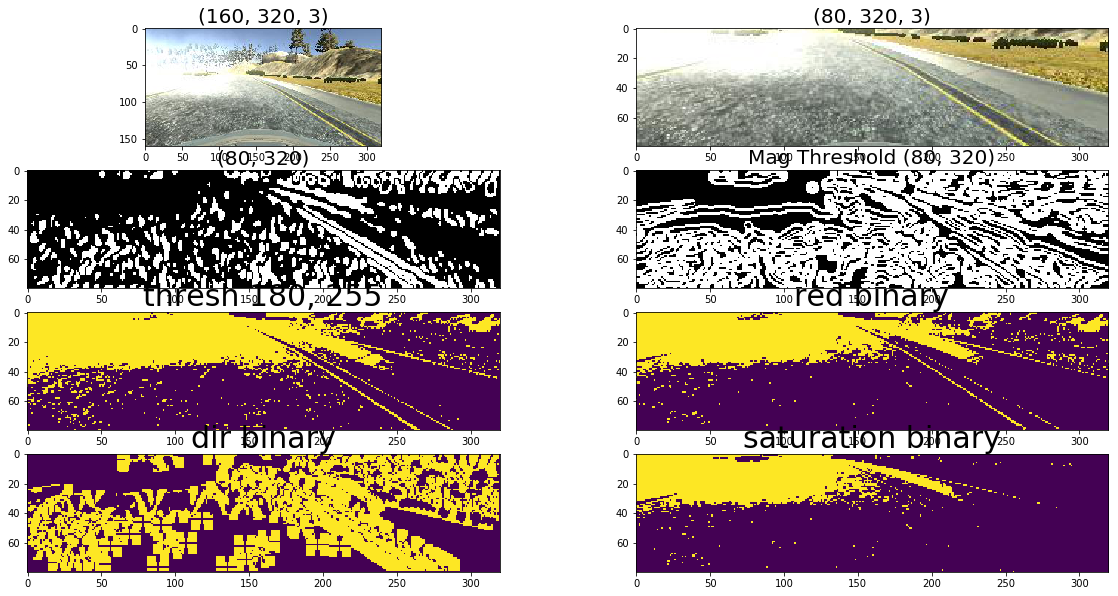

In [30]:
import preprocessing as pro

with open(training_data_base_path + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    row1 = next(reader)
    filename = row1[0].split('/')[-1]
    current_path = base_path + 'IMG/' + filename
#     current_path = '/src/images/input/center_2017_07_21_15_14_25_438_no_border.jpg'
    print(current_path)
    image = mpimg.imread(current_path)
    
    cropped = cv2.resize(image[60:140,:], (320, 80))
    
    ksize = 15
    gradx = pro.abs_sobel_thresh(cropped, orient='x', sobel_kernel=ksize,
                                 thresh_min=0, thresh_max=255)
    grady = pro.abs_sobel_thresh(cropped, orient='y', sobel_kernel=ksize,
                                 thresh_min=0, thresh_max=255)
    
    mag_binary = pro.mag_thresh(grady, sobel_kernel=ksize, mag_thresh=(50, 200))
    
    gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)
    thresh = (180, 255)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    
    R = cropped[:,:,0]
    G = cropped[:,:,1]
    B = cropped[:,:,2]
    thresh = (200, 255)
    rbinary = np.zeros_like(R)
    rbinary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    dir_binary = pro.dir_threshold(rbinary, sobel_kernel=ksize, thresh=(0.1, 1.3))
    
    hls = cv2.cvtColor(cropped, cv2.COLOR_RGB2HLS)
    H = cropped[:,:,0]
    L = cropped[:,:,1]
    S = cropped[:,:,2]
    thresh = (200, 255)
    sbinary = np.zeros_like(S)
    sbinary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    
    
    
    
    
#     plot
    f, ((ax1, ax2),(ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20, 10))
    ax1.imshow(image)
    ax1.set_title(image.shape, fontsize=20)

    ax2.imshow(cropped)
    ax2.set_title(cropped.shape, fontsize=20)
    
    ax3.imshow(gradx, cmap='gray')
    ax3.set_title(grady.shape, fontsize=20)
    
    ax4.imshow(mag_binary, cmap='gray')
    ax4.set_title('Mag Threshold ' + str(mag_binary.shape), fontsize=20)
    
    ax5.imshow(binary)
    ax5.set_title('thresh 180, 255', fontsize=30)
    
    ax6.imshow(rbinary)
    ax6.set_title('red binary', fontsize=30)
    
    ax7.imshow(dir_binary)
    ax7.set_title('dir binary', fontsize=30)
    
    ax8.imshow(sbinary)
    ax8.set_title('saturation binary', fontsize=30)

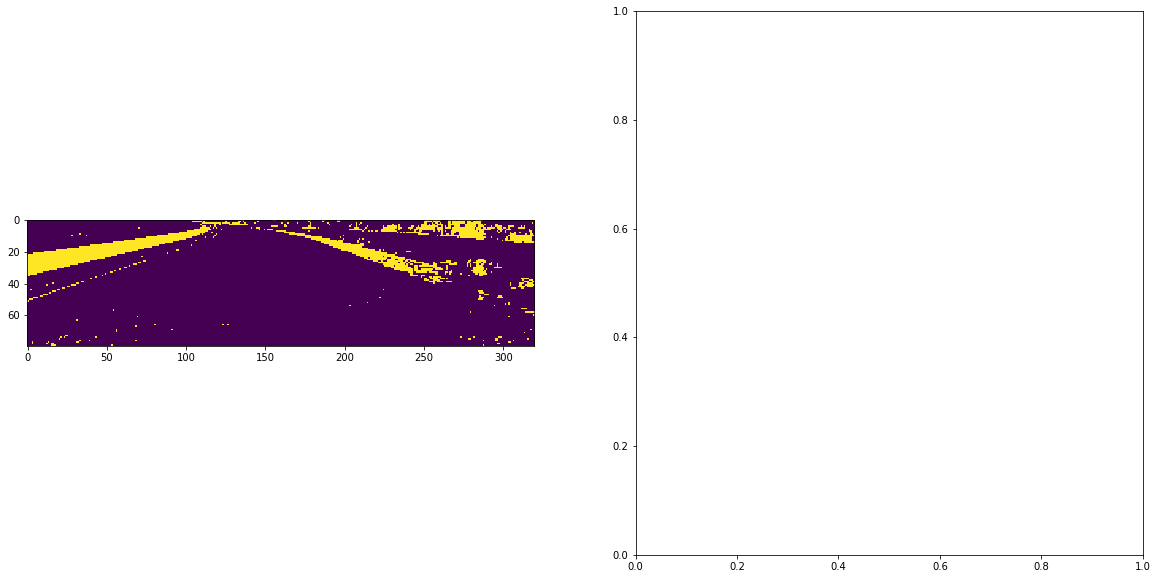

In [31]:
current_path = '/src/images/input/center_2017_07_21_15_14_25_438_no_border.jpg'
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(image_process(current_path))

In [32]:
samples = []
with open(training_data_base_path + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)


'''
images = []
measurements = []

for line in train_samples:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = base_path + 'IMG/' + filename
#     image = cv2.imread(current_path)
    # image = cv2.resize(image[60:140,:], (64,64))
    images.append(current_path)
    measurement = float(line[3])
    measurements.append(measurement)
'''

"\nimages = []\nmeasurements = []\n\nfor line in train_samples:\n    source_path = line[0]\n    filename = source_path.split('/')[-1]\n    current_path = base_path + 'IMG/' + filename\n#     image = cv2.imread(current_path)\n    # image = cv2.resize(image[60:140,:], (64,64))\n    images.append(current_path)\n    measurement = float(line[3])\n    measurements.append(measurement)\n"

In [33]:
'''
# Data Augmentation
str_imgs, str_msr, agl_imgs, agl_msr = augmentation.split_straight_angle(images, measurements)
str_images, str_measurements = str_imgs, str_msr # augmentation.remove_excess_straigth_drive(str_imgs, str_msr, len(agl_imgs)/len(str_imgs))
agl_images, agl_measurements = augmentation.invert_images_and_measurements(agl_imgs, agl_msr)

# X_train = np.array(images)
# y_train = np.array(measurements)
X_train = np.array(str_images + agl_images)
y_train = np.array(str_measurements + agl_measurements)

print("straight images count: ", len(str_images), "measurements count: ", len(str_measurements), len(X_train))
print("angle images count: ", len(agl_images), "measurements count: ", len(agl_measurements), len(y_train))

images = []
measurements = []
for line in validation_samples:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = base_path + 'IMG/' + filename
    image = cv2.imread(current_path)
    # image = cv2.resize(image[60:140,:], (64,64))
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)

X_val = np.array(images)
y_val = np.array(measurements)
'''

'\n# Data Augmentation\nstr_imgs, str_msr, agl_imgs, agl_msr = augmentation.split_straight_angle(images, measurements)\nstr_images, str_measurements = str_imgs, str_msr # augmentation.remove_excess_straigth_drive(str_imgs, str_msr, len(agl_imgs)/len(str_imgs))\nagl_images, agl_measurements = augmentation.invert_images_and_measurements(agl_imgs, agl_msr)\n\n# X_train = np.array(images)\n# y_train = np.array(measurements)\nX_train = np.array(str_images + agl_images)\ny_train = np.array(str_measurements + agl_measurements)\n\nprint("straight images count: ", len(str_images), "measurements count: ", len(str_measurements), len(X_train))\nprint("angle images count: ", len(agl_images), "measurements count: ", len(agl_measurements), len(y_train))\n\nimages = []\nmeasurements = []\nfor line in validation_samples:\n    source_path = line[0]\n    filename = source_path.split(\'/\')[-1]\n    current_path = base_path + \'IMG/\' + filename\n    image = cv2.imread(current_path)\n    # image = cv2.res

In [34]:
# initialize generators
train_gen = generator(train_samples ,batch_size=32)
val_gen = generator(validation_samples ,batch_size=32)
# test_gen = generate_training_data(image_paths_test, angles_test, validation_flag=True, batch_size=64)

In [35]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
# from keras.layers.advanced_activations import ELU

model = Sequential()
# normaliastion of training data.
# https://keras.io/layers/convolutional/#cropping2d
# model.add(Cropping2D(cropping=((64, 23),(0, 0)), input_shape=(160, 320, 3)))
# model.add(Lambda(lambda x: ((x/255.0)-0.5), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: ((x/255.0)-0.5), input_shape=(100, 180, 3)))
model.add(Conv2D(6,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(6,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(4,3,3, activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(127))
# model.add(Dropout(0.5))
model.add(Dense(84))
# model.add(ELU)
model.add(Dense(24))
# model.add(ELU)
# model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
# model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=1)

# model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=1)
model.fit_generator(train_gen, samples_per_epoch = math.ceil(len(train_samples)),
                    nb_epoch=1, validation_data = val_gen, nb_val_samples = len(validation_samples))
#     history = model.fit_generator(train_gen, validation_data=val_gen, nb_val_samples=2560, samples_per_epoch=23040, 
#                                   nb_epoch=5, verbose=2, callbacks=[checkpoint])

Epoch 1/1


ValueError: Error when checking model input: expected lambda_input_2 to have 4 dimensions, but got array with shape (80, 320)

In [ ]:
# https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
model_json = model.to_json()
with open(results_file +".json", "w") as json_file:
  json_file.write(model_json)
model.save(results_file +'.h5')
model.summary()
from keras.utils import plot_model
plot_model(model, to_file=results_file + '.png')